# Lesson 6: Bayesian Data Analysis

## Intro to Quantified Cognition

By: Per B. Sederberg, PhD

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2021_Spring/notebooks/06_Bayesian_Data_Analysis.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Hierarchical models
- Deep dive into various Bayesian models of one dataset
- Explore other datasets
- Real-world data analysis in teams


In [ ]:
# if on Google Colab
#!pip install git+https://github.com/arviz-devs/arviz
!pip install arviz

# to retrieve the dists.py and data files
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/dists.py
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/flanker_dat.csv
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/rdm_dataframe.csv

In [1]:
# load matplotlib inline mode
%matplotlib inline

# Turn off future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

import pymc3 as pm
import theano.tensor as T
import arviz as az

from sklearn import preprocessing

import dists

## Hierarchical Regression

What should we do when we have multiple groups/subjects?

Ideally we should share information across groups to inform the models fit to the individuals.

This is called multi-level or hierarchical modeling.

## Flanker dataset

We will explore a number of ways to analyze a flanker task dataset. 

You can then use these as a guide when you analyze some of the other datasets we have available.

In [2]:
# load some data
dat = pd.read_csv('flanker_dat.csv', index_col=None)

# remove nans
dat = dat[~np.isnan(dat['rt'])]

dat.head()

,appear_time_time,condition,corr_resp,correct,datetime,loc_x,loc_y,log_time,press_time_error,press_time_time,pressed,rt,run_num,stim,subj
0,1787.897096,~,F,True,20180917_131349,6.123234e-17,1.000000,1788.663548,0.000487,1788.663548,F,0.766451,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101
1,1789.522516,~,J,True,20180917_131349,7.071068e-01,-0.707107,1790.983430,0.000479,1790.983430,J,1.460914,0,__>__\n_><>_\n><><>\n_><>_\n__>__\n,101
2,1791.939483,~,F,True,20180917_131349,-1.836970e-16,-1.000000,1792.928294,0.000980,1792.928294,F,0.988812,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101
3,1793.739963,=,J,True,20180917_131349,1.000000e+00,0.000000,1794.552259,0.000489,1794.552259,J,0.812296,0,__<__\n_<><_\n<>>><\n_<><_\n__<__\n,101
4,1795.340368,~,F,True,20180917_131349,-7.071068e-01,-0.707107,1796.055466,0.000478,1796.055466,F,0.715098,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101


In [3]:
# let's check out the conditions
for s in dat.stim.unique():
    print(s)

__<__
_<><_
<><><
_<><_
__<__

__>__
_><>_
><><>
_><>_
__>__

__<__
_<><_
<>>><
_<><_
__<__

__<__
_<<<_
<<<<<
_<<<_
__<__

__>__
_>>>_
>>>>>
_>>>_
__>__

__>__
_><>_
><<<>
_><>_
__>__



In [4]:
# get various ways to index the data
# see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = preprocessing.LabelEncoder()
subj_idx = le.fit_transform(dat['subj'])
cond_idx = le.fit_transform(dat['condition'])
n_subj = len(dat.subj.unique())
n_cond = len(dat.condition.unique())


In [5]:
# usually best to look at log rt
dat['log_rt'] = np.log(dat['rt'])

# also add in some info about where the stimuli were presented
dat['abs_x'] = np.round(np.abs(dat.loc_x), decimals=3)
dat['abs_y'] = np.round(np.abs(dat.loc_y), decimals=3)
dat['angle_rad'] = np.arctan2(dat.loc_y, dat.loc_x)
dat['angle_deg'] = dat['angle_rad']*180/np.pi


# show the columns we have to work with
dat.columns

Index(['appear_time_time', 'condition', 'corr_resp', 'correct', 'datetime',
       'loc_x', 'loc_y', 'log_time', 'press_time_error', 'press_time_time',
       'pressed', 'rt', 'run_num', 'stim', 'subj', 'log_rt', 'abs_x', 'abs_y',
       'angle_rad', 'angle_deg'],
      dtype='object')

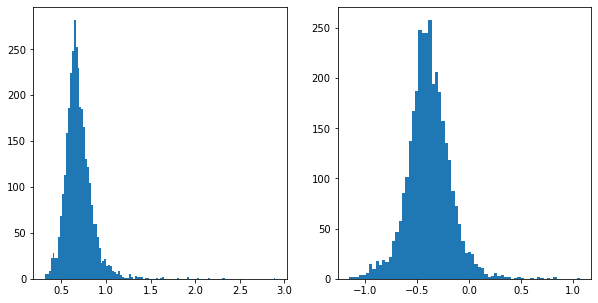

In [6]:
# show how distribution of log_rts is mostly normal
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.hist(dat['rt'].values, bins='auto');
plt.subplot(1,2,2)
plt.hist(dat['log_rt'].values, bins='auto');


## Explore effects on reaction time

In [7]:
print('Overall mean:', dat.log_rt.mean())
print('Overall std:', dat.log_rt.std())

Overall mean: -0.38980821568002116
Overall std: 0.21076148021266058


### Hierarchical version of *t*-test

In [8]:
# define the hierarchical model
with pm.Model() as hierarchical_model:
    
    # hyperprior for mu
    mu_mu = pm.Normal('mu_mu', 
                        mu=dat.log_rt.mean(), 
                        sd=dat.log_rt.std()*2,
                        shape=n_cond)
    sigma_mu = pm.HalfCauchy('sigma_mu', 10, shape=n_cond)
    
    # prior on mu
    mu = pm.Normal('mu', mu_mu, sigma_mu, 
                   shape=(n_subj, n_cond))
    
    # hyperprior for sd (Gelman suggests gamma prior)
    sd_scale = pm.Gamma('sd_scale', .5, .5,
                        shape=n_cond)
    
    # prior on sd
    sd = pm.HalfCauchy('sd', sd_scale, 
                       shape=(n_subj, n_cond))
    
    # prior on df (fixed for all params)
    nu = pm.Exponential('df_minus_one', 1/29.) + 1.
    
    # likelihood
    log_rt_like = pm.StudentT('log_rt_like', 
                              mu=mu[subj_idx, cond_idx], 
                              sd=sd[subj_idx, cond_idx],
                              nu=nu,
                              observed=dat.log_rt)
    
    # save out some comparisons of interest
    mudiff01 = pm.Deterministic('mu_diff_01', mu_mu[1]-mu_mu[0])
    mudiff02 = pm.Deterministic('mu_diff_02', mu_mu[2]-mu_mu[0])
    mudiff12 = pm.Deterministic('mu_diff_12', mu_mu[2]-mu_mu[1])

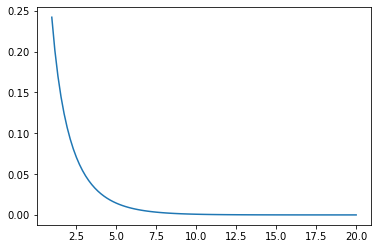

In [9]:
# Examine gamma prior on the half cauchy scale
x = np.linspace(1, 20, 100)
plt.plot(x, np.exp(pm.Gamma.dist(.5, .5).logp(x).eval()))

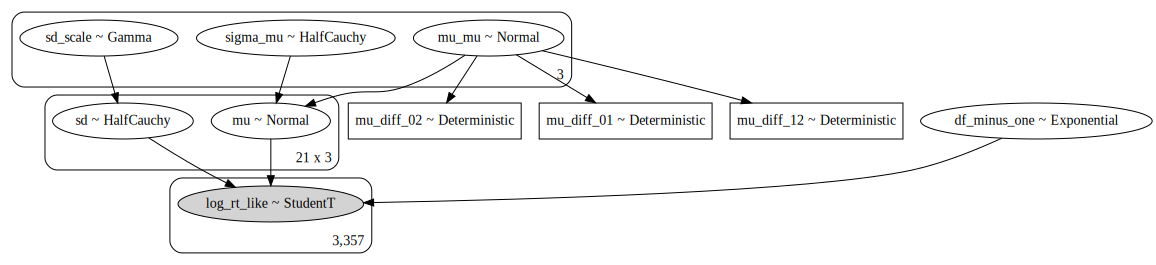

In [10]:
pm.model_to_graphviz(hierarchical_model)

In [11]:
with hierarchical_model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [df_minus_one, sd, sd_scale, mu, sigma_mu, mu_mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:24<00:00, 200.46draws/s]


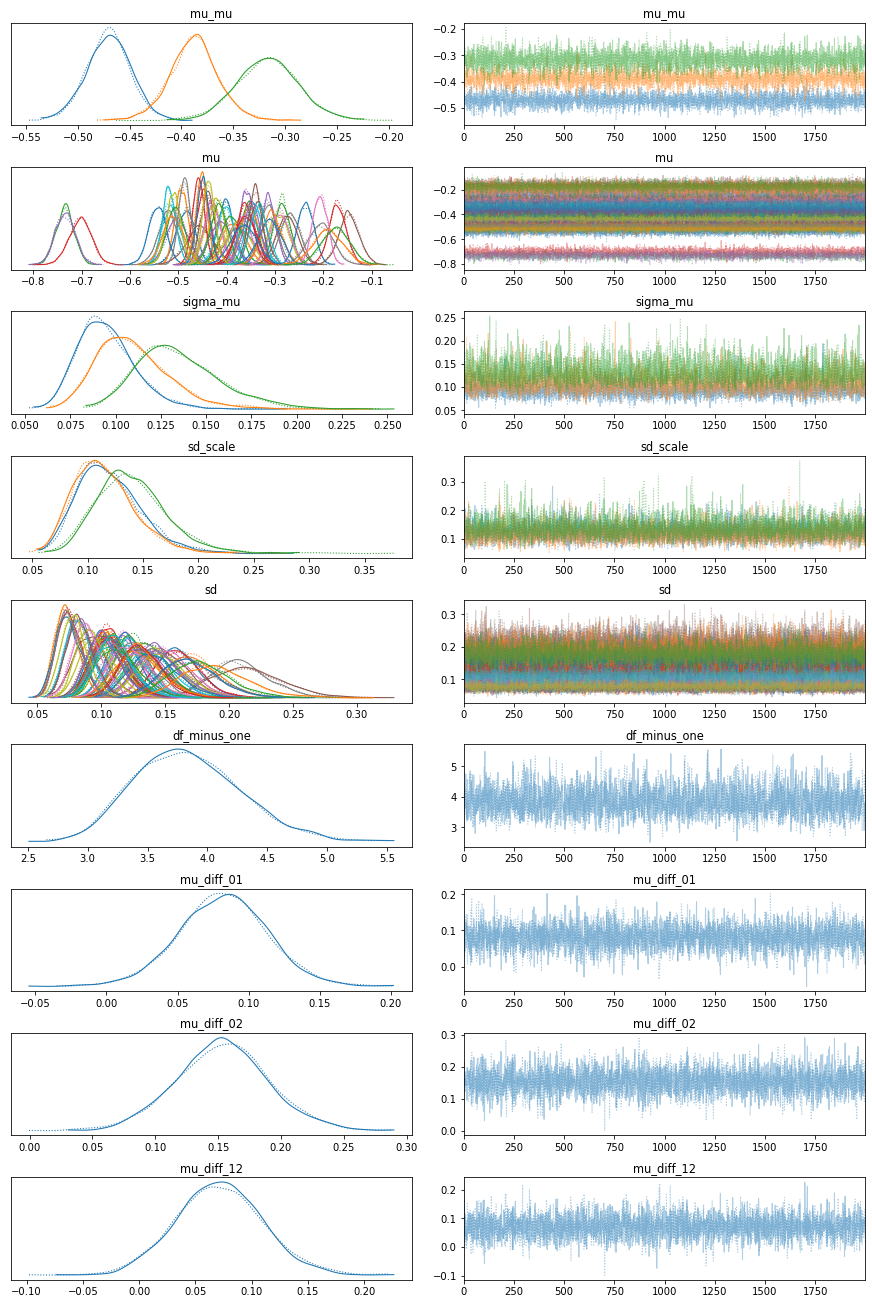

In [12]:
# check our traces
pm.traceplot(trace);

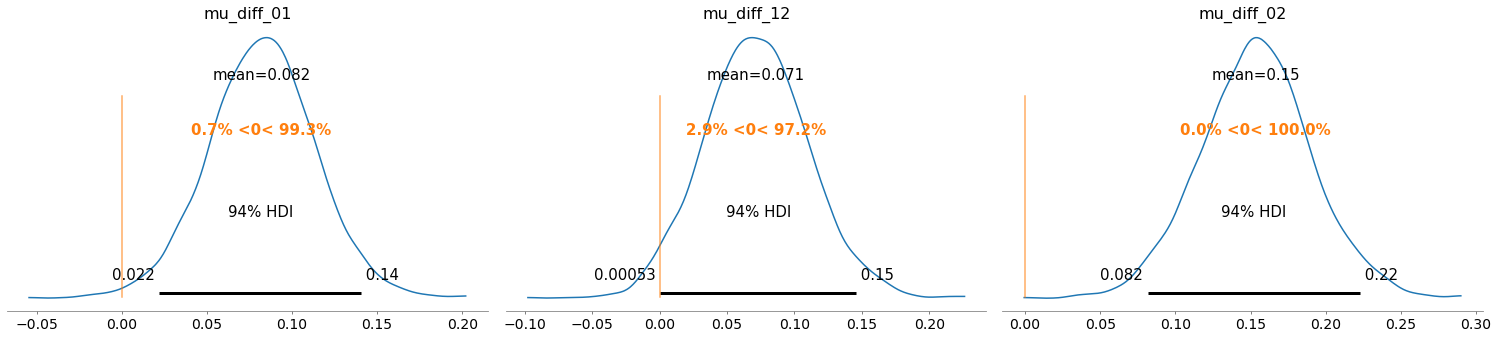

In [13]:
# show comparisons of interest
pm.plot_posterior(trace, var_names=['mu_diff_01', 'mu_diff_12', 'mu_diff_02'], 
                  ref_val=0.0);

### Hierarchical version of linear model

In [14]:
# need to make a numerical condition variable
dat['num_cond'] = 0
dat.loc[dat['condition']=='=', 'num_cond'] = 1
dat.loc[dat['condition']=='~', 'num_cond'] = 2
dat.num_cond.unique()

array([2, 1, 0])

In [15]:
dat.head()

,appear_time_time,condition,corr_resp,correct,datetime,loc_x,loc_y,log_time,press_time_error,press_time_time,...,rt,run_num,stim,subj,log_rt,abs_x,abs_y,angle_rad,angle_deg,num_cond
0,1787.897096,~,F,True,20180917_131349,6.123234e-17,1.000000,1788.663548,0.000487,1788.663548,...,0.766451,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101,-0.265984,0.000,1.000,1.570796,90.0,2
1,1789.522516,~,J,True,20180917_131349,7.071068e-01,-0.707107,1790.983430,0.000479,1790.983430,...,1.460914,0,__>__\n_><>_\n><><>\n_><>_\n__>__\n,101,0.379062,0.707,0.707,-0.785398,-45.0,2
2,1791.939483,~,F,True,20180917_131349,-1.836970e-16,-1.000000,1792.928294,0.000980,1792.928294,...,0.988812,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101,-0.011251,0.000,1.000,-1.570796,-90.0,2
3,1793.739963,=,J,True,20180917_131349,1.000000e+00,0.000000,1794.552259,0.000489,1794.552259,...,0.812296,0,__<__\n_<><_\n<>>><\n_<><_\n__<__\n,101,-0.207890,1.000,0.000,0.000000,0.0,1
4,1795.340368,~,F,True,20180917_131349,-7.071068e-01,-0.707107,1796.055466,0.000478,1796.055466,...,0.715098,0,__<__\n_<><_\n<><><\n_<><_\n__<__\n,101,-0.335335,0.707,0.707,-2.356194,-135.0,2


In [16]:
# define the hierarchical model
with pm.Model() as hierarchical_linear_model:
    # Hyperpriors for group nodes
    mu_inter = pm.Normal('mu_inter', mu=dat.log_rt.mean(), sd=dat.log_rt.std()*10)
    sigma_inter = pm.HalfCauchy('sigma_inter', 10)
    
    mu_slope = pm.Normal('mu_slope', mu=0., sd=dat.log_rt.std()*10)
    sigma_slope = pm.HalfCauchy('sigma_slope', 10)

    # Intercept for each subj, distributed around group mean
    intercept = pm.Normal('intercept', mu=mu_inter, 
                          sd=sigma_inter, shape=n_subj)
    
    # slope for each subj, distributed around group mean
    slope = pm.Normal('slope', mu=mu_slope, 
                      sd=sigma_slope, shape=n_subj)

    # Model error
    eps = pm.HalfCauchy('eps', 10)
    
    # define the means predicted from a linear function
    log_rt_est = intercept[subj_idx] + slope[subj_idx] * dat.num_cond.values

    # Data likelihood (could also replace with Student's t)
    log_rt_like = pm.Normal('log_rt_like', 
                            mu=log_rt_est, 
                            sd=eps, 
                            observed=dat.log_rt)
    
    # Data with Student's t likelihood
    # prior on df (fixed for all params)
    #nu = pm.Exponential('df_minus_one', 1/29.) + 1.
    #log_rt_like = pm.StudentT('log_rt_like', mu=log_rt_est, sd=eps, nu=nu, observed=dat.log_rt)


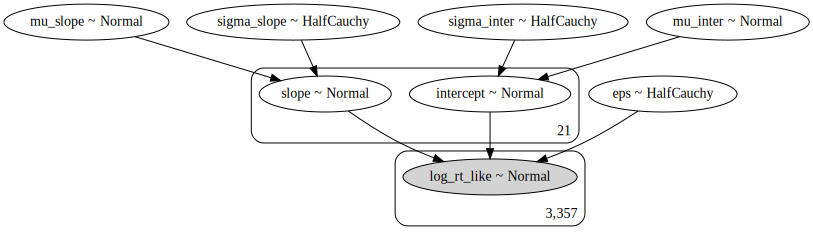

In [17]:
pm.model_to_graphviz(hierarchical_linear_model)

In [18]:
with hierarchical_linear_model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, slope, intercept, sigma_slope, mu_slope, sigma_inter, mu_inter]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 533.31draws/s]


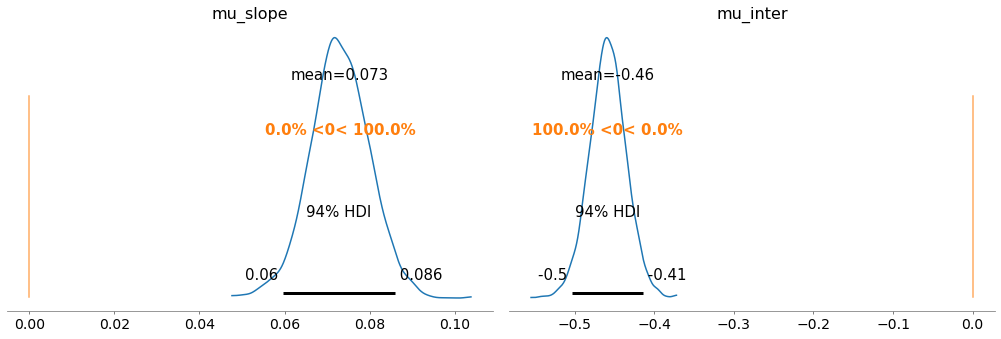

In [19]:
pm.plot_posterior(trace, var_names=['mu_slope', 'mu_inter'], ref_val=0.0);

### More-complicated linear model

In [26]:
# define the hierarchical model
with pm.Model() as hierarchical_linear_model_y:
    # Hyperpriors for group nodes
    mu_inter = pm.Normal('mu_inter', mu=dat.log_rt.mean(), sd=dat.log_rt.std()*10)
    sigma_inter = pm.HalfCauchy('sigma_inter', 10)
    
    mu_slope_cond = pm.Normal('mu_slope_cond', mu=0., sd=dat.log_rt.std()*10)
    sigma_slope_cond = pm.HalfCauchy('sigma_slope_cond', 10)
    mu_slope_y = pm.Normal('mu_slope_y', mu=0., sd=dat.log_rt.std()*10)
    sigma_slope_y = pm.HalfCauchy('sigma_slope_y', 10)

    # Intercept for each subj, distributed around group mean
    intercept = pm.Normal('intercept', mu=mu_inter, sd=sigma_inter, shape=n_subj)
    
    # slope for each subj, distributed around group mean
    slope_cond = pm.Normal('slope_cond', mu=mu_slope_cond, sd=sigma_slope_cond, shape=n_subj)
    slope_y = pm.Normal('slope_y', mu=mu_slope_y, sd=sigma_slope_y, shape=n_subj)

    # Model error
    eps = pm.HalfCauchy('eps', 10)
    
    # define the means predicted from a linear function
    log_rt_est = (intercept[subj_idx] + slope_y[subj_idx] * dat.abs_y.values + 
                  slope_cond[subj_idx] * dat.num_cond.values)

    # Data likelihood (could also replace with Student's t)
    #log_rt_like = pm.Normal('log_rt_like', mu=log_rt_est, sd=eps, observed=dat.log_rt)
    
    # Data with Student's t likelihood
    # prior on df (fixed for all params)
    nu = pm.Exponential('df_minus_one', 1/29.) + 1.
    log_rt_like = pm.StudentT('log_rt_like', mu=log_rt_est, sd=eps, nu=nu, observed=dat.log_rt)


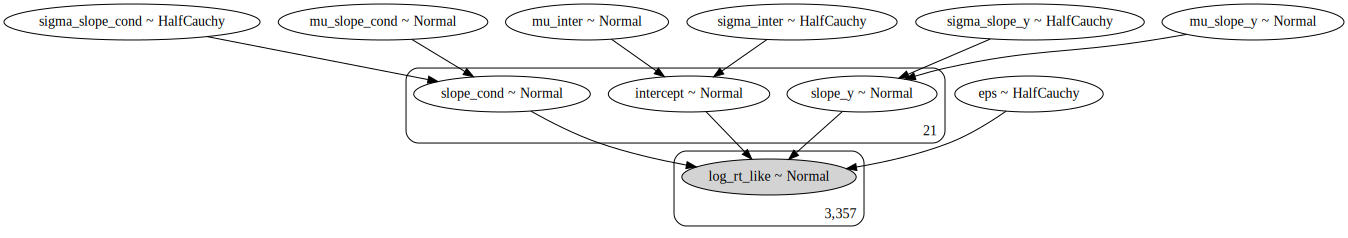

In [27]:
pm.model_to_graphviz(hierarchical_linear_model_y)

In [28]:
with hierarchical_linear_model_y:
    trace_y = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, slope_y, slope_cond, intercept, sigma_slope_y, mu_slope_y, sigma_slope_cond, mu_slope_cond, sigma_inter, mu_inter]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:20<00:00, 241.90draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


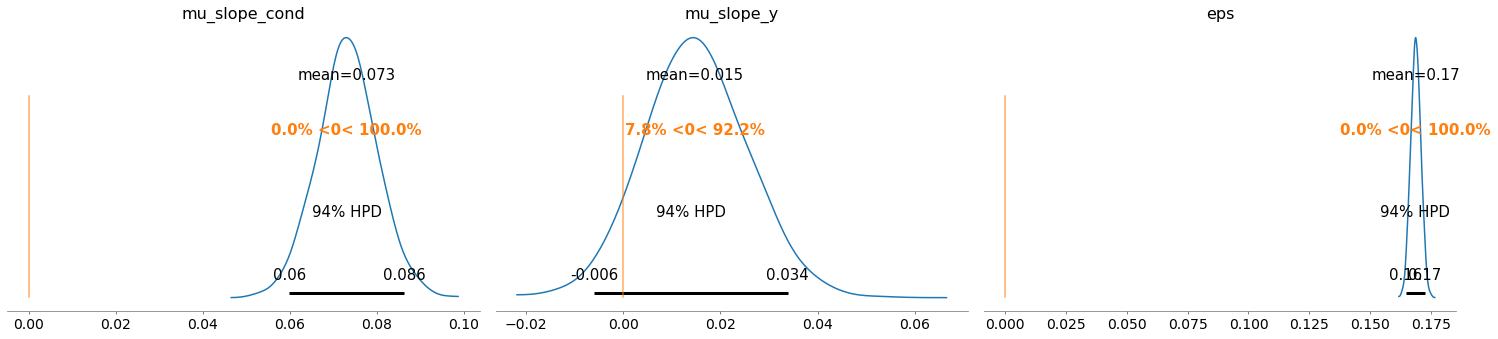

In [30]:
pm.plot_posterior(trace_y, var_names=['mu_slope_cond', 'mu_slope_y', 'eps'], ref_val=0.0);

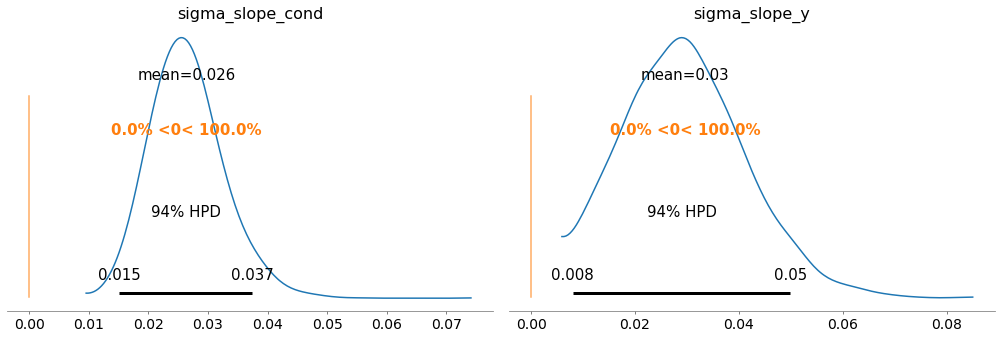

In [36]:
pm.plot_posterior(trace_y, var_names=['sigma_slope_cond', 'sigma_slope_y'], ref_val=0.0);

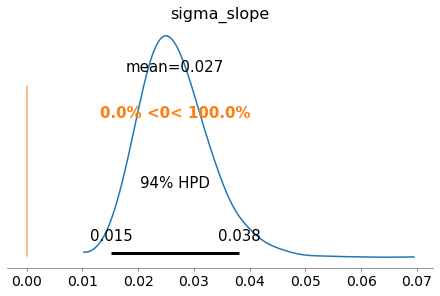

In [38]:
pm.plot_posterior(trace, var_names=['sigma_slope'], ref_val=0.0);

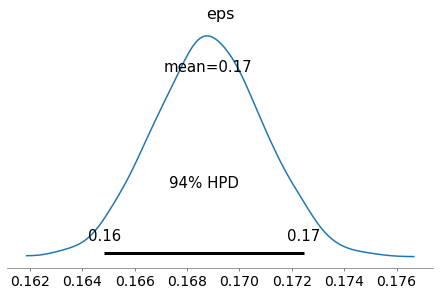

In [33]:
pm.plot_posterior(trace_y, var_names=['eps']);

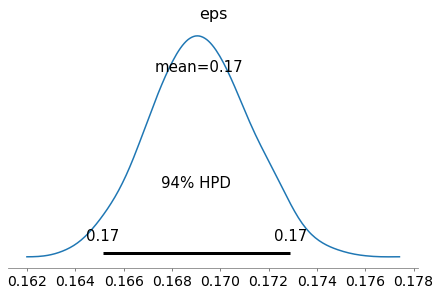

In [34]:
pm.plot_posterior(trace, var_names=['eps']);

In [39]:
# perform a model comparison
az.compare({'no_y': az.from_pymc3(trace), 'with_y': az.from_pymc3(trace_y)})

/home/per/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
with_y,0,-2370.93,48.1741,0,0.651705,168.938,0,True,deviance
no_y,1,-2368.12,38.274,2.80088,0.348295,170.397,6.61054,True,deviance


## Evaluate percent correct

In [ ]:
# how about mean performance
dat.groupby(['condition'])['correct'].mean()

In [ ]:
dat.groupby(['condition'])['correct'].mean().plot()

In [ ]:
# define the hierarchical model
with pm.Model() as perf_model:
    
    # prior on mu (one for each cond)
    mu = pm.TruncatedNormal('mu',
                            mu=dat.correct.mean(), 
                            sd=dat.correct.std()*2, 
                            lower=0.0, upper=1.0,
                            shape=n_cond)
    
    # prior on sd (one for each cond)
    sd = pm.HalfCauchy('sd', 0.1, shape=n_cond)
    
    # likelihood
    prob = pm.Beta('beta', 
                   mu=mu,
                   sd=sd,
                   shape=(n_subj, n_cond))
    
    perf = pm.Binomial('perf', 
                       n=1,
                       p=prob[subj_idx, cond_idx],
                       observed=dat.correct)
    
    # save out some comparisons of interest
    mudiff01 = pm.Deterministic('mu_diff_01', mu[1]-mu[0])
    mudiff02 = pm.Deterministic('mu_diff_02', mu[2]-mu[0])
    mudiff12 = pm.Deterministic('mu_diff_12', mu[2]-mu[1])
    
    sddiff01 = pm.Deterministic('sd_diff_01', sd[1]-sd[0])
    sddiff02 = pm.Deterministic('sd_diff_02', sd[2]-sd[0])
    sddiff12 = pm.Deterministic('sd_diff_12', sd[2]-sd[1])


In [ ]:
# explore some priors
x = np.linspace(0, 1, 100)
#y = np.exp(pm.Beta.dist(mu=.5, sd=.15).logp(x).eval())
y = np.exp(pm.HalfCauchy.dist(.1).logp(x).eval())
#y = np.sqrt(x*(1-x))
#y = np.exp(pm.TruncatedNormal.dist(mu=dat.correct.mean(), 
#                              sd=dat.correct.std()*2, 
#                              lower=0.0, upper=1.0).logp(x).eval())
plt.plot(x, y)

In [ ]:
with perf_model:
    trace = pm.sample(2000, cores=2)

In [ ]:
# check our traces
#pm.traceplot(trace);

In [ ]:
# show comparisons of interest
pm.plot_posterior(trace, var_names=['mu_diff_01', 'mu_diff_12', 'mu_diff_02', 
                                   'sd_diff_01', 'sd_diff_12', 'sd_diff_02'], 
                  ref_val=0.0);

In [ ]:
# how to do the comparison by hand
probs = trace.get_values('beta')
print(probs.shape)
plt.hist(probs[:,0,0]-probs[:,0,1], bins='auto', alpha=.3);
plt.hist(probs[:,0,1]-probs[:,0,2], bins='auto', alpha=.3);
plt.axvline(0.0)

## Random Dot Motion (RDM) data

In [ ]:
df = pd.read_csv('rdm_dataframe.csv', index_col='Unnamed: 0')
df.head()

In [ ]:
df.coherence.unique()

In [ ]:
# add in some columns of interest
df['log_rt'] = np.log(df.rt)
df['coh_diff'] = np.abs(df.left_coherence - df.right_coherence)
df.head()

In [ ]:
plt.hist(df['rt'], bins='auto');

In [ ]:
# clean the data a bit
df = df.loc[df.rt >= .25]
plt.hist(df.log_rt, bins='auto');

In [ ]:
df.groupby(['coh_diff'])['log_rt'].mean().plot()